In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#QPU connection
try:
    from qat.qlmaas import QLMaaSConnection
    connection = QLMaaSConnection(hostname="qlm")#, port=...)
    LinAlg = connection.get_qpu("qat.qpus:LinAlg")
    lineal_qpu = LinAlg()
except ImportError:
    from qat.qpus import PyLinalg
    lineal_qpu = PyLinalg()

Username: gferro
········


## 1. Quantum Multiplexors

Implementation of loading data routines using the *Lov Grover and Terry Rudolph* routines directly, using controlled rotations by state, is highly inneficient. In general the use of controlled rotations generate highly deep quantum circuits prone to errors. 
A more efficient approach is the use of Quantum Multiplexors where the only controlled gates are c-Not ones. 

The operation we want to implement is a controlled rotation on an angle $\theta_i$ controlled by a state $|i\rangle$. 

For a 2 qbits state the operator should be:

$$
\hat{U}|q_0q_1\rangle= \{ \begin{array}{ll}
      |0\rangle\hat{R}_y(\theta_0)|q_1\rangle  & if \;|q_0\rangle = |0\rangle \\
      |1\rangle\hat{R}_y(\theta_1)|q_1\rangle  & if \;|q_0\rangle = |1\rangle \\
\end{array}
$$

With a quantum multiplexor this operation can be implemented as:

$$\hat{U}(\theta_0, \theta_1)|q_0q_1\rangle= \left( \mathbf{I} \otimes \hat{R}_{y} (\frac{\theta_0+\theta_1}{2}) \right) \hat{C}_{NOT} \left(\mathbf{I} \otimes \hat{R}_{y} (\frac{\theta_0-\theta_1}{2}) \right) \hat{C}_{NOT}|q_0q_1\rangle$$

The circuit representation for this operator is:

![alt text](./QM_01.png)

As can be seen the quantum multiplexor needs only $C_{NOT}$ gates that are implemented in easier way than controlled rotations


For controlled state rotations of more angles quantum multiplexors can be implemented in a recursively way. For example if we want apply a controlled 4 angle rotation $[\theta_0, \theta_1, \theta_2, \theta_3]$ we can use following circuit:

![alt text](./QM_02.png)


In general a quantum multiplexor with $m$ control qubits can be decomposed as 2 multiplexors with $m − 1$ control qubits and 2 $\hat{C}_{NOT}$ gates:
![alt text](./QM_03.png)

In the **QuantumMultiplexors_Module** there are an implementation for a quantum multiplexor controlled by $m$ qbits and the functions neede to use them in order to load probability and a Integral function

## 2. QuantumMultiplexors_Module

In order to use this module the basic functions are:
1. LoadProbability_Gate: Loads a probability distribution in a quantum state using multiplexors
2. LoadIntegralFunction_Gate: Loads the integral of a function in a quantum state using multiplexors.

In order to do the data loading we need to discretizate it so:

In [4]:
from AuxiliarFunctions import  get_histogram, PostProcessResults, TestBins
def p(x):
    return x*x
def f(x):
    return np.sin(x)

In [5]:
#number of Qbits for the circuit
n_qbits = 8
#The number of bins 
m_bins = 2**n_qbits
LowerLimit = 0.0
UpperLimit = 1.0 

X, p_X = get_histogram(p, LowerLimit, UpperLimit, m_bins)
f_X = f(X)

### 2.1 LoadProbability_Gate

In order to show how use this gate we use following function **LoadProbabilityProgram**. As can be seen the gate needs  the center of the bins (*X*) and the probability of the center (*p_X*)

In [6]:
def LoadProbabilityProgram(p_X, X):
    """
    Creates a Quantum Program for loading an input numpy array with a probability distribution.
    Inputs:
        * p_X: np.array. Probability distribution of size m. Mandatory: m=2^n where n is the number
        * X: np.array. Centers of the bins od the probability distribution.
        qbits of the quantum circuit. 
    Outputs:
        * qprog: qlm program for loading input probability
    """
    #Qbits of the Quantum circuit depends on Probability length
    nqbits = TestBins(p_X, 'Probability')
    
    from qat.lang.AQASM import Program
    qprog = Program()
    qbits = qprog.qalloc(nqbits)
    #Creation of P_gate
    from QuantumMultiplexors_Module import LoadProbability_Gate
    P_gate = LoadProbability_Gate(p_X, X)
    #Apply Abstract gate to the qbits
    qprog.apply(P_gate, qbits)
    return qprog


In [7]:
circuit_P = LoadProbabilityProgram(p_X, X).to_circ()

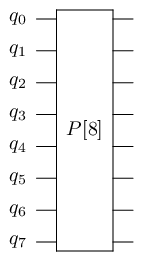

In [8]:
%qatdisplay circuit_P --depth 0

In [9]:
jobP = circuit_P.to_job()
resultP = lineal_qpu.submit(jobP)
P_results = PostProcessResults(resultP.join())
np.isclose(P_results['Probability'], p_X).all()

Submitted a new batch: Job267


True

In [10]:
P_results.head()

,States,Probability,Amplitude
0,|00000000>,4.470365e-08,0.000211+0.000000j
1,|00000001>,4.023329e-07,0.000634+0.000000j
2,|00000010>,1.117591e-06,0.001057+0.000000j
3,|00000011>,2.190479e-06,0.001480+0.000000j
4,|00000100>,3.620996e-06,0.001903+0.000000j


### 2.2 LoadIntegralFunction_Gate

In order to show how use this gate we use following function **LoadProbabilityProgram**. As can be seen the gate needs  the center of the bins (*X*) and the probability of the center (*p_X*)